<h1> 1.1 </h1>
<body>
<font size = "2" color = "red">->Put raw csv in same path as ipynb for smooth running of code </font><br><br>

<font size = "3">This part of the code finds the number of houses in to whole dataset,<br>
outputs <b><i>clean_df</i></b> csv for further processing,<br>
marks out the time period of all malfunction meter</font><br><br>

In 1.1 we are supposed to generate a collections malfunction. We will first need to define what data points are counted as<br> malfunction, then we need to extract them. We have defined malfunction to be of these types:<br><br>
 1: data reported back when change in gas use is < 2 cubic foot<br>
 2: data reported back new meter_value is smaller than old meter_value<br>
 3: data reported back is >2, but time > 15s, threshold value for reporting malfunction will be 7 cubic foot/hr<br> 
 (US household average daily usage = 168 cubic foot)<br>
 If report between 2 reading is > 168, the extra high reading will be treated as malfunction and dropped away<br>
 4: However, continuous report of same reading from same id over 12hrs,<br>
 the first reading after 12hrs will be treated as good reading,<br>
 as the gas company will probably want to know whether is a meter malfunctioning<br>
 even though its reading did not change for a period of time<br><br>

And these are the main problems that we encountered,<br>
- Finding efficient method to loop through the whole dataset, extracting what we want<br>
- Looping through the dataset, removing what we don't want.<br>

</body>

In [1]:
import numpy as np
import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
import timeit
from datetime import timedelta
from pathlib import Path
# start_time = timeit.default_timer() * 1000
currentPath = str(Path().resolve())
# Put raw csv in same 
path = currentPath + "./dataport-export_gas_oct2015-mar2016.csv"

# Read in raw data and find 
df = pd.read_csv(path)
data_id = df['dataid'].nunique()
print("Number of houses =", data_id)

Number of houses = 157


In [2]:
# Sort data into order by id, if same id then by time
df.sort_values(["dataid", "localminute"], ascending=[True, True], inplace = True)
df.reset_index(drop = True, inplace = True)

# Cast localminute into proper time format for further processing
df.localminute = df.localminute.str.slice(0,19)
df.localminute = pd.to_datetime(df.localminute, infer_datetime_format = True, format = "%Y/%m/%d %I:%M:%S %p")
print(df.localminute[0])
print("Length of df:", len(df))

2015-10-01 00:14:44
Length of df: 1584823


In [3]:
# Types of malfunction
# 1: data reported back when change in gas use is < 2 cubic foot
# 2: data reported back new meter_value is smaller than old meter_value
# 3: data reported back is >2, but time > 15s, threshold value for reporting malfunction will be 7 cubic foot/hr 
# (US household average daily usage = 168 cubic foot) https://www.aga.org/sites/default/files/aga_2961_2015_aga_playbook_final_0.pdf
# If report between 2 reading is > 168, the extra high reading will be treated as malfunction and dropped away
# 4: However, continuous report of same reading from same id over 12hrs,
# the first reading after 12hrs will be treated as good reading,
# as the gas company will probably want to know whether is a meter malfunctioning
# even though its reading did not change for a period of time

# Progress bar cuz I always feel it is not working
# f = FloatProgress(min=0, max=(len(df['dataid']) - 1))
# display(f)

# Create empty df and array for more efficient removal of item in df
malfunction = pd.DataFrame(columns = ["localminute", "dataid", "meter_value"])
bad_array = []
to_drop = []

prev_good = True
_id = None
_12hr = None
# Sort malfunction with time period label
# Assumption: the first data point is always correct as the 2nd pt is wrt to it, 3rd wrt to 2nd....etc
# Append malfunction period and data to respective array
for row in df.itertuples():
    if(_id is None or _id != row.dataid):
        prev_good = True
        _id = row.dataid
    # for estimating time take to process actual data
    if (row.Index == 0):
        continue
    #1 and #2
    if (((row.meter_value <= df.meter_value[row.Index-1])
         and (row.dataid == df.dataid[row.Index-1])) 
        or ((row.localminute != df.localminute[row.Index-1]) 
            and (row.dataid == df.dataid[row.Index-1]) 
            and ((row.meter_value - df.meter_value[row.Index-1]) < 2))):
        if(prev_good == True):
            bad_array.append([_id, row.localminute, row.localminute])
            to_drop.append(row.Index)
            #4, update 12hr pt
            _12hr = row.localminute
        else:
            #4  
            if ((row.localminute - _12hr) >= pd.to_timedelta("12:00:00")):
                prev_good = True
                continue
            else:                
                if ((df.meter_value[row.Index - 1] - row.meter_value) < 168):
                    to_drop.append(row.Index)
                    bad_array[-1][2] = row.localminute                    
        prev_good = False
    else:
        #3
        if ((row.meter_value - df.meter_value[row.Index - 1]) < 168):
            if(((row.meter_value - df.meter_value[row.Index-1]) > 2) 
               and ((((row.localminute - df.localminute[row.Index-1]) / timedelta(hours = 1)) * 7) 
                    > (row.meter_value - df.meter_value[row.Index - 1]))):
                bad_array[-1][2] = row.localminute
            prev_good = True
        else:
            to_drop.append(row.Index)
            prev_good = False
            bad_array[-1][2] = row.localminute
            
print("Length of bad_array:", len(bad_array))
print("Length of to_drop:", len(to_drop))

Length of bad_array: 167948
Length of to_drop: 1258484


In [4]:
#Remove malfunction data to produce clean df
df.drop(index = to_drop, inplace = True)
df.reset_index(drop = True, inplace = True)

# # Cast to int64
# malfunction['dataid'] = malfunction['dataid'].astype(np.int64)
# malfunction['meter_value'] = malfunction['meter_value'].astype(np.int64)

# # Merge 2 df to compare diff, if one of the label value is different,
# # value in _merge label will be different hence being able to differeniate the difference
# df = pd.merge(df, malfunction, on=['localminute', 'dataid', 'meter_value'], how='outer', indicator=True)\
# .query("_merge != 'both'")\
# .drop(['_merge'], axis=1)\
# .reset_index(drop=True)

# Convert bad_array into df and transform it for shape to be correct
malfunction = pd.DataFrame(bad_array, columns = ['dataid', 'start_time', 'end_time'])
malfunction.T

# Save part1 result into csv for easier access in part2
df.to_csv('./clean_df.csv', index = False)
malfunction.to_csv('./malfunction.csv', index = False)

# pd.set_option('display.max_rows', 10000)

# elapsed = timeit.default_timer() * 1000 - start_time
# print("total: %ds" %(elapsed/1000)) if ((elapsed > 5000) == True) else print("total: %dms" %elapsed)
print("length of df:", len(df))
print("length of malfunction:", len(malfunction))

length of df: 326339
length of malfunction: 167948


<h1>1.2</h1>
In 1.2 we are supposed to generate hourly readings for different ids. The hourly readins will starts from the fisrt availble data point and end at the last available data point of the particular id, since we can hardly deduce the data point prior to the first point and after the last point. 

There are three main cases that we need to handle: 
1. A few (more than 1) consecutive data are within the same hour: in this case, we keep the last reading as the hourly reading because the last reading reflects the highest consumption of the hour
2. The two consecutive datas are consecutive in time as well: in this case, we can savely keep the prior reading of the pair as the hourly reading.
3. The two consecutive datas are more than one hour apart: in this case, there is missing data in between the two points and we need to fill in. This case can be furthure separated to 3 sub-cases:
    3.1--The two consecutive data have identical meter_value: this means that there is no increase in value throughout the preiod, hence the missing hours have reading same as the closet available data.
    3.2--The two consecutive data have different value and the value is less than 4: this means that there is increase during the period, but this increase is very likely to occur in the last hour, hence we will let missing hours' reading equal to their previous closest available reading.
    3.3--The two consecutive data have different value and the value is more than 4: in this case, there is high possibility that in some hours, there is consumption but the meter fails to report. Hence, we will evenly distribute the difference among the missing hours. 

In [5]:
import pandas as pd
import numpy as np
import timeit
import datetime as dt 
import matplotlib.pyplot as plt

In [6]:
#import result from 1.1

gas_data = pd.read_csv("clean_df.csv")
len(gas_data)

326339

In [7]:
#preprocessing data for easier computation in the following: change datatype of 'localminute' to datetime
#change datatype of 'meter_value' to float

start_time = timeit.default_timer()
gas_data.localminute = gas_data.localminute.str.slice(0,19)
gas_data.localminute = pd.to_datetime(gas_data.localminute, infer_datetime_format = True, 
                                      format = "%Y/%m/%d %I:%M:%S %p");
gas_data.localminute = gas_data.localminute.map(lambda x:x.replace(minute=0, second=0));
gas_data['meter_value']=gas_data['meter_value'].astype(float)

In [8]:
ind=0;
#creating a constant timedelta object with value =1 hr for comparison
_hr=dt.timedelta(hours=1);
temp_gas_hr=pd.DataFrame(columns=gas_data.columns);
temp_gas_hr=gas_data;
id_list=gas_data['dataid'].unique();
#creating an id list for itertaion since only comparison of reading within id is meanningful

#creating dummy list for appending later
missing_lm=[];
missing_id=[];
missing_val=[];

for _id in id_list:
    
    #generate hourly readings according to dataid
    temp_gas_data=gas_data[gas_data['dataid']==_id];
    temp_gas_data.reset_index(drop=True,inplace=True);
    
    for  row in temp_gas_data.itertuples():
        if(row.Index==0):
            prev_row=pd.Series(data=[row.localminute,row.dataid,row.meter_value]
                               ,index=['localminute','dataid','meter_value']);
            #unable to predict datapoints before the first available datapoint and afer the last datapoint
            #hence the hourly reading starts from the first available local minute and end at the last one.
        else:
            
            time_diff=row.localminute-prev_row.localminute;
            #determine if there is any missing data before two consecutive available data
            #if there is the difference in hour of two consecutive available data is large than one
            #there is missing data
            
            if(time_diff>_hr):
                time_diff=int(time_diff.total_seconds()/3600);
                #determine how many datapoints are missing
                
                for j in range (1,time_diff):
                    if ((row.meter_value-prev_row.meter_value)>4):
                        #if the difference between two available datepoint is too large,
                        #this means that there is missing distinct datapoints in between.
                        acc_reading=float((row.meter_value-prev_row.meter_value)/time_diff);
                    else:
                        #if the difference is not large, the missing datapoint has value 
                        #equals to the previous datapoint
                        acc_reading=0;
                    time_change=dt.timedelta(hours=j);
                    new_time=prev_row.localminute+time_change;
                    missing_lm.append(new_time);
                    missing_id.append(_id);
                    missing_val.append(float(prev_row.meter_value+acc_reading*j));

        prev_row=pd.Series(data=[row.localminute,row.dataid,row.meter_value]
                               ,index=['localminute','dataid','meter_value']);
       #make a copy the current available data for comparison in next iteration


In [9]:
#concatenate the missing data with original data
missing_data={'localminute':missing_lm,'dataid':missing_id,'meter_value':missing_val};
missing_data=pd.DataFrame(missing_data,columns=gas_data.columns);
temp_gas_hr=pd.concat([gas_data,missing_data]);

In [10]:
temp_gas_hr=temp_gas_hr.sort_values(by=['dataid','localminute']);
temp_gas_hr.drop_duplicates(['localminute','dataid'],keep='last',inplace=True); 

#for the same hour, if there is multiple readings, keep the highest value
temp_gas_hr['meter_value']=temp_gas_hr['meter_value'].astype(int)
print("total: %ds" %(timeit.default_timer() - start_time))

total: 205s


In [11]:
temp_gas_hr.to_csv('hourly_readings_final.csv',index=False);

<h1><font color = "red">Run this cell only if generating graphs</font></h1>
<h5>may take 3 hours</h5>

In [12]:
#gas_hr=temp_gas_hr;
#gas_hr=gas_hr[(gas_hr['localminute'].dt.year==2016)&(gas_hr['localminute'].dt.month==1)]
#mon_inc=2;
#mon_dec=12;
#for _id in id_list:
#    mon_inc=2;
#    mon_dec=12;
#    temp_id_hr=gas_hr[gas_hr['dataid']==_id];
#    while(len(temp_id_hr)==0):
#        temp_id_hr=temp_gas_hr[temp_gas_hr['dataid']==_id];
#        temp_id_hr.reset_index(drop=True,inplace=True);
#        if((temp_id_hr.at[len(temp_id_hr)-1,'localminute'].year<2016)&(temp_id_hr.at[len(temp_id_hr)-1,'localminute'].month<=12)):
#            temp_id_hr=temp_gas_hr[(temp_gas_hr['localminute'].dt.year==2015)&(temp_gas_hr['localminute'].dt.month==mon_dec)
#                              &(temp_gas_hr['dataid']==_id)];
#            mon_dec=mon_dec-1;
#        else: 
#            temp_id_hr=temp_gas_hr[(temp_gas_hr['localminute'].dt.year==2016)&(temp_gas_hr['localminute'].dt.month==mon_inc)
#                              &(temp_gas_hr['dataid']==_id)];
#            mon_inc=mon_inc+1;
#    temp_id_hr.reset_index(drop=True,inplace=True);
#    t='Hourly reading of '+str(_id)+' of '+str(temp_id_hr.at[0,'localminute'].month)+' in '+str(temp_id_hr.at[0,'localminute'].year);
#    fig=plt.figure(figsize=(15,15));
#    plt.plot(temp_id_hr.localminute,temp_id_hr.meter_value);
#    plt.xlabel('date hr/(hr)');
#    plt.ylabel('meter_value'),
#    plt.title(t,loc='center');
#    plt.grid();
#    t_fig=t+'.png';
#    fig.savefig(t_fig);
#    plt.show();

<h1>1.3</h1>
In 1.3 we are required to compute the correlations between the gas consumption of every two households, and for each household, find out 5 other households with the highest correlation in gas consumption.

This part of the code reads the <b><i>hourly_readings_final</i></b>.csv file which is generated in the previous section (1.2) and outputs <b><i>top_correlated_households</i></b>.csv. The main problem faced in this section is how the correlation should be computed. The initial idea was to calculate only based on hourly readings computed in 1.2 without considering time. However, many of the households do not have complete data, which means in some month, these households do not have any meter readings. Thus simply computing correlation based on hourly readings is not sufficient.

The method used for 1.3 is to compute the average gas consumption for each household in each hour. The hourly consumption is computed first by comparing the readings between adjacent readings for the same household. After getting the hourly consumption, the mean of all readings in each hour is computed, as it is reasonable to say that by including more data points, the average can be more representative compared to taking a few data points. For each household, there are 24 data points for average hourly consumption, representing the 24 hours. Correlation matrix can be computed from the average hourly consumption, and the top 5 households with highest correlation can be found

In [13]:
import pandas as pd
import numpy as np
import datetime as dt 
from collections import namedtuple

In [14]:
# 1.3
# import result obtained from 1.2
hourly_reading = pd.read_csv('./hourly_readings_final.csv')

# get the list of dataids
idList = hourly_reading['dataid'].drop_duplicates(keep = 'first')
idList = idList.reset_index(drop = True)

# split the column 'localminute' into 'day' and 'time'
new_time = hourly_reading['localminute'].str.split(" ", n = 1, expand = True)
hourly_reading['day'] = new_time[0]
hourly_reading['time'] = new_time[1]
hourly_reading.drop(columns = ['localminute'], inplace = True)

In [15]:
# print out all readings from household 6101 to show the
# insufficient information available for this household
print(hourly_reading.loc[hourly_reading.dataid == 6101])

        dataid  meter_value         day      time
400406    6101       114832  2016-01-20  21:00:00


In [16]:
# add the 'diffs' column which shows the hourly consumption by each household
# the function diff() computes the difference between the current data point and the previous data point
# therefore the data points at the boundary (data id changes) are wrong and will be changed to NaN
hourly_reading['diffs'] = hourly_reading['meter_value'].diff()
mask = (hourly_reading.dataid != hourly_reading.dataid.shift(1))
hourly_reading.loc[mask, 'diffs'] = np.nan

# compute the average hourly consumption by each household
# save all the values in the average_hourly_consumption dataframe created
average_hourly_consumption = pd.DataFrame(np.random.randint(low = 0.0, high = 10.0, size = (24, len(idList))), columns = idList)
for col in idList:
    for hr in range (0, 23):
#         set the criteria for selecting the data points
        if hr < 10:
            criterion = hourly_reading['time'].map(lambda x: (x[0] ==  '0') & (x[1] == str(hr)))
        if hr >= 10:
            criterion = hourly_reading['time'].map(lambda x: (x[0] == str(hr)[0]) & (x[1] ==  str(hr)[1]))
#         compute the mean of hourly consumption for each household and insert into average_hourly_consumption dataframe
        average_hourly_consumption.loc[hr, col] = hourly_reading.loc[(hourly_reading.dataid == col) & criterion]['diffs'].mean()

In [17]:
# compute the correlation matrix of the new dataframe
corr = average_hourly_consumption.corr()

# remove the 1s in diagonal
# as the correlation between a column and itself is always 1
corr -= np.eye(corr.shape[0])

# create a new dataframe with random values inserted
top_corr = pd.DataFrame(np.random.randint(low = 0.0, high = 10.0, size = (5 * (len(idList) - 1), 3)), columns = ['HH1', 'HH2', 'corr']).reset_index(drop = True)

# set 'corr' column data type as float64
# since correlation value is a floating point between 0 and 1
top_corr['corr'] = top_corr['corr'].astype(float)

In [18]:
# loop through all data ids in the correlation matrix
# for each data id, find out the 5 data ids with the highest correlation values
# collate all results in the top_corr dataframe
count = 0
for i in corr.columns[:]:
    temp_corr = corr.nlargest(5, i)
    
#     since household 6101 has very limited information (only one available datum)
#     it is discarded in the calculation of correlations between households
    if i != 6101:
        for j in range (0, 5):
            top_corr.loc[count, 'HH1'] = i
            top_corr.loc[count, 'HH2'] = temp_corr.index[j]
            top_corr.loc[count, 'corr'] = temp_corr[i].iloc[j]
            count += 1

# export top_corr dataframe as csv file
top_corr.to_csv('top_correlated_households.csv', index = False)

<h1>1.4</h1>

In our proposal, we would like to analyze the gas consumption data further by applying clustering method to measure the similarity between the households, and group them based on energy usage. The goal in clustering time‐series data is to understand user behavior by organizing the data into homogeneous groups, maximizing the similarity and dissimilarity within and between groups, respectively.

Clustering is a collection of same group similar or data objects or in other groups. Its also finding the dissimilar to the data objects in other groups.In cluster analysis, the main objective is to find similarities between data objects with the help of specific characteristics found in the data and grouping these similar data objects into clusters. In our project, the following features and their respective standard deviation will be examined in the following clustering discussion.    

<table>
<tr>
<th>Features</th>
<th>Discription</th>
</tr>
<tr>
<td>Total consumption</td>
<td>Total consumed power during period of the study</td>
</tr>
<tr>
<td>Morning consumtption</td>
<td>The consumption observed from 06:00 - 09:00</td>
</tr>
<tr>
<td>Noon consumtption</td>
<td>The consumption observed from 11:00 - 14:00</td>
</tr>
<tr>
<td>Night consumtption</td>
<td>The consumption observed from 17:00 - 20:00</td>
</tr>
</table>

Potential application areas for work using this form of cluster analysis as more smart data becomes routinely available include
1. Application of cluster results for segment-specific rate design: the economic benefits of time-variable natural gas rates consist in the potential for utilities to improve price discrimination and to facilitate the reduction of peak loads. A complete design of gas scheme would encompass number of different time zones and starting time of each period. All these could be done through clustering analysis. In addition, by influencing the demand side, segment-specific natural gas rates can improve the energy system’s efficiency.

2. Application of cluster results for leak detection activities based on detecting pattern changes (deviation from cluster centroids/ distributions); data-driven models of demand could also help identify atypical customers or unusual changes in consumption. 

3. Application of cluster results for filling missing data for audits/ regulatory purposes using cluster centroids. Typical usage perhaps allowS volumetric usage and flow profiles to be estimated for unmetered customers.

In [19]:
import numpy as np
import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
from pathlib import Path
import timeit
import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pylab as pl
from sklearn.decomposition import PCA
from IPython.display import HTML
from sklearn.datasets import load_iris
from sklearn import preprocessing

In [20]:
path = str(Path().resolve().parent)+'\csv'
df = pd.read_csv(path+"/hourly_consumption.csv")

df.localminute = df.localminute.str.slice(0,19)
df.localminute = pd.to_datetime(df.localminute, infer_datetime_format = True, 
                                      format = "%Y/%m/%d %I:%M:%S %p");
headers = ["dataid", "totoalConsumption", "morningMean", "morningSTD", "noonMean",
          "noonSTD", "nightMean", "nightSTD"]
df.localminute = df.localminute.map(lambda x:x.replace(minute=0, second=0));
currentID = df.iloc[0]['dataid']
baseTime = df.iloc[0]['localminute'] 
featuresList = []
morningConsumption = []
noonConsumption = []
nightConsumption = []
totoalConsumption = 0
currentMorning = 0
currentNoon = 0
currentNight = 0
prevDay = 0

In [21]:
# Feature Extraction 
for row in df.itertuples():
    time_diff = str(row.localminute - baseTime)
    hrs_diff = int(time_diff.split(" ")[2][:2])
    day_diff = int((time_diff.split(" ")[0]))
    if (day_diff != prevDay):
        morningConsumption.append(currentMorning)
        noonConsumption.append(currentNoon)
        nightConsumption.append(currentNight)
        prevDay = day_diff
        currentMorning = 0
        currentNoon = 0
        currentNight = 0
        
    if (currentID != row.dataid):
        features = []
        morningMean = np.mean(morningConsumption)
        morningSTD = np.std(morningConsumption)
        noonMean = np.mean(noonConsumption)
        noonSTD = np.std(noonConsumption)
        nightMean = np.mean(nightConsumption)
        nightSTD = np.std(nightConsumption)
        features.append(currentID)
        features.append(totoalConsumption)
        features.append(morningMean)
        features.append(morningSTD)
        features.append(noonMean)
        features.append(noonSTD)
        features.append(nightMean)
        features.append(nightSTD)
        featuresList.append(features)
        
        morningConsumption = []
        noonConsumption = []
        nightConsumption = []
        totoalConsumption = 0
        currentID = row.dataid
    
    totoalConsumption = totoalConsumption + int(row.meter_value)
    if (hrs_diff >= 6 and hrs_diff < 9):
        currentMorning = currentMorning + int(row.meter_value)
    elif (hrs_diff >= 11 and hrs_diff < 14):
        currentNoon = currentNoon + int(row.meter_value)
    elif (hrs_diff >= 17 and hrs_diff < 20):
        currentNight = currentNight + int(row.meter_value)

morningConsumption.append(currentMorning)
noonConsumption.append(currentNoon)
nightConsumption.append(currentNight)
morningMean = np.mean(morningConsumption)
morningSTD = np.std(morningConsumption)
noonMean = np.mean(noonConsumption)
noonSTD = np.std(noonConsumption)
nightMean = np.mean(nightConsumption)
nightSTD = np.std(nightConsumption)
features = []

features.append(currentID)
features.append(totoalConsumption)
features.append(morningMean)
features.append(morningSTD)
features.append(noonMean)
features.append(noonSTD)
features.append(nightMean)
features.append(nightSTD)
featuresList.append(features)

featureFrame = pd.DataFrame(featuresList)
featureFrame.to_csv(path + '/reading_features.csv', header=headers, index=None)

K-medoids clustering selects the most centrally located data points within clusters as cluster centers called medoids and returns the number of clustering as required.

In [22]:
df = pd.read_csv(path+"/reading_features.csv")
featureNames = ["totoalConsumption", "morningMean", "noonMean", "nightMean"]


x = df[featureNames].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x_scaled = min_max_scaler.fit_transform(x)
df_normalized = pd.DataFrame(x_scaled)

kmeans = KMeans(n_clusters=3).fit(df_normalized)
df.insert(loc=0, column="classification", value=kmeans.labels_)
df.to_csv(path + '/reading_features_classification.csv', index=None)

Text(0,0.5,'Morning Average Consumption')

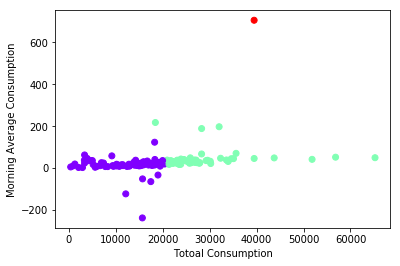

In [23]:
df_array = df.values
plt.scatter(df_array[:,2],df_array[:,3], c=kmeans.labels_, cmap='rainbow')  
plt.xlabel('Totoal Consumption')
plt.ylabel('Morning Average Consumption')

Text(0,0.5,'Noon Average Consumption')

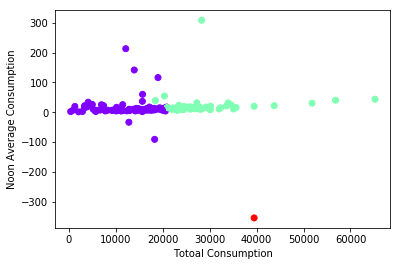

In [24]:
df_array = df.values
plt.scatter(df_array[:,2],df_array[:,5], c=kmeans.labels_, cmap='rainbow')  
plt.xlabel('Totoal Consumption')
plt.ylabel('Noon Average Consumption')

Text(0,0.5,'Night Average Consumption')

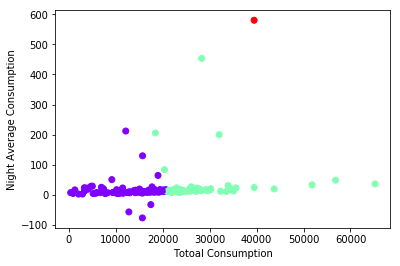

In [25]:
df_array = df.values
plt.scatter(df_array[:,2],df_array[:,7], c=kmeans.labels_, cmap='rainbow')  
plt.xlabel('Totoal Consumption')
plt.ylabel('Night Average Consumption')

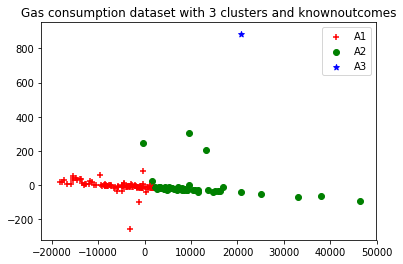

In [26]:
pca = PCA(n_components=2).fit(df[featureNames])
pca_2d = pca.transform(df[featureNames])
for i in range(0, pca_2d.shape[0]):
    if df.classification[i] == 0:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='+')
    elif df.classification[i] == 1:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='o')
    elif df.classification[i] == 2:
        c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='*')
pl.legend([c1, c2, c3], ['A1', 'A2','A3'])
pl.title('Gas consumption dataset with 3 clusters and knownoutcomes')
pl.show()

In conclusion, data clustering is used to find similar groups having the same gas consumption patterns. Smart meter data clustering has been widely investigated toward consumers grouping and revealing their energy usage behavior which leads to more efficient tariff policy and tailored energy efficiency programs for specific users. More specific data analysis and comparison will be shown in section 3.